In [1]:
import os
import datetime
#import json
import numpy as np
import pandas as pd
#import matplotlib.pyplot as plt
#import matplotlib
#from pandas_datareader import data, wb  # Testing of datareader package
#matplotlib.style.use('ggplot')

# Initial Data Setup
start_date = '2015-05-01'
start_date = datetime.datetime.strptime(start_date, '%Y-%m-%d')

In [2]:
data_path = 'C:/Users/Bing/github/longrun/data'
vxv_file = os.path.join(data_path, 'vxv.csv')
vxmt_file = os.path.join(data_path, 'vxmt.csv')
xiv_file = os.path.join(data_path, 'xiv.csv')
vxx_file = os.path.join(data_path, 'vxx.csv')
svxy_file = os.path.join(data_path, 'svxy.csv')
hvi_file = os.path.join(data_path, 'svxy.csv')
dateparse = lambda x: pd.datetime.strptime(x, '%d/%m/%Y')

vxv_df = pd.read_csv(vxv_file, index_col=0, parse_dates=[0], date_parser=dateparse)
vxmt_df = pd.read_csv(vxmt_file, index_col=0, parse_dates=[0], date_parser=dateparse)
vxx_df = pd.read_csv(vxx_file, index_col=0, parse_dates=[0], date_parser=dateparse)
xiv_df = pd.read_csv(xiv_file, index_col=0, parse_dates=[0], date_parser=dateparse)
svxy_df = pd.read_csv(svxy_file, index_col=0, parse_dates=[0], date_parser=dateparse)
hvi_df = pd.read_csv(hvi_file, index_col=0, parse_dates=[0], date_parser=dateparse)
xiv = xiv_df[['Adj Close']]
vxx = vxx_df[['Adj Close']]
svxy = svxy_df[['Adj Close']]
hvi = hvi_df[['Adj Close']]



In [23]:
# calc ratios and signals
data = pd.merge(vxv_df, vxmt_df, how='left', left_index=True, right_index=True)
data = data.fillna(method='ffill')
data = data.fillna(value=0)
# Derived vix futures ratio and moving averages below
ratio = data['VXV'].divide(data['VXMT'])
ratio.sort_index(axis='index', inplace=True)
ratio.name = 'ratio'
ma_60 = pd.Series.rolling(ratio, window=60).mean()
ma_150 = pd.Series.rolling(ratio, window=150).mean()
ma_60.name = 'ma_60'
ma_150.name = 'ma_150'

strat_df = pd.concat([ratio, ma_60, ma_150],  axis=1)
idx = strat_df.isnull().any(axis=1)
strat_df = strat_df[~idx]
strat_df = strat_df[strat_df.index >= start_date]


etf = pd.merge(xiv, vxx, how='left', left_index=True, right_index=True)
etf = pd.merge(etf, svxy, how='left', left_index=True, right_index=True)
etf = pd.merge(etf, hvi, how='left', left_index=True, right_index=True)
etf.columns = ['xiv', 'vxx', 'svxy', 'hvi']


In [24]:
xiv.head()

,Adj Close
Date,
2016-12-01,41.900002
2016-12-02,41.849998
2016-12-05,44.730000
2016-12-06,46.060001
2016-12-07,45.950001


In [4]:
# First strat df with all etf data and ratio
#longrun = pd.merge(etf, strat_df , how='left', left_index=True, right_index=True)

# Strategy signals can be calculated independent of underlying data first, merge signals with price data later
# 100% Long signal
strat_df['signal'] = np.where((strat_df['ma_60']<1) & (strat_df['ma_150']<1) & (strat_df['ratio'] < strat_df['ma_60']) & (strat_df['ratio'] < strat_df['ma_150']), 1, 0)

# 50% long signal
strat_df['signal_50'] = np.where((strat_df['ma_60']<1) & (strat_df['ma_150']<1) & (strat_df['ratio'] > strat_df['ma_60']) & (strat_df['ratio'] < strat_df['ma_150']), 1, 0)

# Get enter/out signal
idx = np.where(strat_df.signal[1:].values != strat_df.signal[:-1].values)[0] + 1
idx_50 = np.where(strat_df.signal_50[1:].values != strat_df.signal_50[:-1].values)[0] + 1

# Get buy/sell cells for 100% Long
if strat_df.signal[0] == 0:
    buy_idx = idx[::2]
    sell_idx = idx[1::2]
else:
    buy_idx = np.insert(idx[1::2], 0, 0)
    sell_idx = idx[::2]

strat_df['bs'] = ''
strat_df.bs[buy_idx] = 'buy'
strat_df.bs[sell_idx] = 'sell'

# Get buy/sell cells for 50% Long
if strat_df.signal_50[0] == 0:
    buy_50_idx = idx_50[::2]
    sell_50_idx = idx_50[1::2]
else:
    buy_50_idx = np.insert(idx_50[1::2], 0, 0)
    sell_50_idx = idx_50[::2]

strat_df['bs_50'] = ''
strat_df.bs_50[buy_50_idx] = 'buy'
strat_df.bs_50[sell_50_idx] = 'sell'

# Output strat_df to csv
strat_df.to_csv(os.path.join(data_path, 'strat_signal.csv'))



C:\Program Files\Anaconda2\envs\python3\lib\site-packages\ipykernel\__main__.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Program Files\Anaconda2\envs\python3\lib\site-packages\ipykernel\__main__.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Program Files\Anaconda2\envs\python3\lib\site-packages\ipykernel\__main__.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Program Files\Anaconda2\envs\python3\lib\site-packages\ipykernel\__main__.py:37: SettingWithCopyWarning

In [9]:
# Start to build the longrun strat portfolio with underlying stock/etf
# First merge stock with strat_df
all_data = pd.merge(etf, strat_df , how='left', left_index=True, right_index=True)
longrun = all_data[all_data.index >= start_date]
etf_name = 'xiv'
#etf_name = 'svxy'


In [6]:
# Predefined portfolio variables
capital = 0
n_shares = 0
cash = 100
capital_prev = capital
n_prev = n_shares
cash_prev = cash
port_value = capital + cash
port = []

In [7]:
# Record rebalance variables info
n_stock = []
cap_list = []
cash_list = []

In [12]:
# Now shift the underlying price (XIV) backward 1 day to avoid look ahead bias
longrun[etf_name] = longrun[etf_name].shift(-1)
longrun[etf_name].fillna(method='ffill', inplace=True)

In [13]:
# Below are the trade/rebalance logics for the portfolio strating from trade day
for i in np.arange(0, len(longrun.index)):
    price = longrun[etf_name].iloc[i]
    signal = longrun.signal[i]
    signal_50 = longrun.signal_50[i]
    bs = longrun.bs[i]
    bs_50 = longrun.bs_50[i]
    # update today's share and capital from yesterday
    n = n_prev
    capital = capital_prev
    cash = cash_prev

    # enter 50% vix from all cash
    if signal_50 == 1 and bs_50 == 'buy' and bs == '':
        n = cash * 0.5 / price
        capital = n * price
        cash = cash * 0.5

    # Enter 50% into 100% (invest rest of cash into xiv)
    if signal == 1 and bs == 'buy' and signal_50 == 0 and bs_50 == 'sell':
        n = n + cash / price
        capital = n * price
        cash = 0

    # Enter 100% into xiv from all cash
    if signal == 1 and bs == 'buy' and bs_50 == '':
        n = cash / price
        capital = n * price
        cash = 0

    # Unload 50% xiv from 100%
    if signal == 0 and bs == 'sell' and bs_50 == 'buy':
        n = n * 0.5
        capital = n * price
        cash = capital

    # Sell all from 50% position or 100%
    if signal_50 == 0 and bs_50 == 'sell' and bs == '':
        cash = capital + cash
        n = 0
        capital = 0

    # Sell all from 100%
    if signal == 0 and bs == 'sell' and bs_50 == '':
        cash = capital
        n = 0
        capital = 0

    # Hold long position
    if (signal == 1 and bs == '') or (signal_50 == 1 and bs_50 == ''):
        capital = n * price

    n_prev = n
    capital_prev = capital
    cash_prev = cash
    port_value = cash + capital
    port.append(port_value)
    n_stock.append(n)
    cap_list.append(capital)
    cash_list.append(cash)

In [14]:
port_df = longrun[[etf_name]]
port_df['strat'] = port
port_df['n'] = n_stock
port_df['capital'] = cap_list
port_df['cash'] = cash_list


C:\Program Files\Anaconda2\envs\python3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Program Files\Anaconda2\envs\python3\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
C:\Program Files\Anaconda2\envs\python3\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

In [19]:
import matplotlib.pyplot as plt
import matplotlib
from pandas_datareader import data, wb  # Testing of datareader package
matplotlib.style.use('ggplot')

In [20]:
%matplotlib inline  

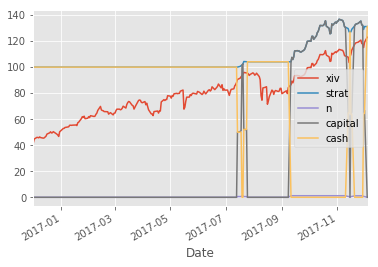

In [21]:
port_df.plot()